# Lyft Bikes trips Data Exploration
## by Dugra Prasad Reddy Kasireddy

In [1]:
# Required Libraries
import requests
from bs4 import BeautifulSoup
import os
from zipp import zipfile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from haversine import haversine, Unit
import geohash2
import datetime
%matplotlib inline

# Data Wrangling
## Gathering Data

In [3]:
# Creating a folder in the local directory
folder_name = 'lyftbikes_csvs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
# Reading the 2017 forgobike tripdata which is already unzipped
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name), index = False)

# Saving the unzipped csv files to the folder created above
""" The HTML does not show the individual links. Hence used loops to run multiple url's"""
years = [2018,2019]
months = np.arange(1,13,1)
for year in years:
    year_string = str(year)
    for month in months:
        if month < 10:
            month_string = str(month).zfill(2)
        else:
            month_string = str(month)
        try:    
            url = 'https://s3.amazonaws.com/fordgobike-data/' + year_string + month_string + '-fordgobike-tripdata.csv.zip'
            response = requests.get(url)
            unzipped_file = zipfile.ZipFile(BytesIO(response.content))
            unzipped_file.extractall(folder_name)
        except :
            print('this url does not exist or BadZipFile')



this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile
this url does not exist or BadZipFile


In [4]:
# Concatinating all the csv files in the folder
list_csvs = []
for file_name in os.listdir(folder_name):
    list_csvs.append(pd.read_csv(folder_name+'/'+file_name))
df = pd.concat(list_csvs, sort= False).reset_index()

## Assessing the Data

In [5]:
# Checking the dataframe
df

,index,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,NaN
1,1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,NaN
2,2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,NaN
5,5,9226,2017-12-31 22:51:00.9180,2018-01-01 01:24:47.1660,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1487,Customer,NaN,NaN,NaN
6,6,4507,2017-12-31 23:49:28.4220,2018-01-01 01:04:35.6190,259.0,Addison St at Fourth St,37.866249,-122.299371,259.0,Addison St at Fourth St,37.866249,-122.299371,3539,Customer,1991.0,Female,NaN
7,7,4334,2017-12-31 23:46:37.1960,2018-01-01 00:58:51.2110,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,1503,Customer,NaN,NaN,NaN
8,8,4150,2017-12-31 23:37:07.5480,2018-01-01 00:46:18.3080,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,3125,Customer,NaN,NaN,NaN
9,9,4238,2017-12-31 23:35:38.1450,2018-01-01 00:46:17.0530,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,2543,Customer,NaN,NaN,NaN


In [6]:
# Dropping the additional index column created while concatenating the csvs
df.drop(columns= ['index'],inplace = True)

In [7]:
# Checking the head of the df to make sure the index column is dropped
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,NaN
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,NaN
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 397.3+ MB


As the number of rows are too many the non null values are not being displayed

In [9]:
# Changing the type of start_time and end_time
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

In [10]:
# Changing the type of member_birth_year and member_gender as categorical 
df.member_gender = df.member_gender.astype('category')
df.user_type = df.user_type.astype('category')

In [11]:
# Change bike_id to string
df.bike_id = df.bike_id.astype(str)

In [12]:
# Cheking the datatypes of each column
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  category
member_birth_year          float64
member_gender              category
bike_share_for_all_trip    object
dtypes: category(2), datetime64[ns](2), float64(7), int64(1), object(4)
memory usage: 353.8+ MB


In [13]:
#describing the datatypes
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,member_birth_year
count,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.036159e+06
mean,8.743223e+02,1.209191e+02,3.776880e+01,-1.223530e+02,1.191966e+02,3.776874e+01,-1.223519e+02,1.983137e+03
std,2.468547e+03,1.030184e+02,1.029275e-01,1.601559e-01,1.029334e+02,1.342571e-01,3.220803e-01,1.043760e+01
min,6.100000e+01,3.000000e+00,0.000000e+00,-1.224737e+02,3.000000e+00,0.000000e+00,-1.224737e+02,1.878000e+03
25%,3.510000e+02,3.100000e+01,3.777106e+01,-1.224117e+02,3.000000e+01,3.777143e+01,-1.224108e+02,1.978000e+03
50%,5.570000e+02,8.800000e+01,3.778107e+01,-1.223983e+02,8.700000e+01,3.778127e+01,-1.223974e+02,1.985000e+03
75%,8.730000e+02,1.880000e+02,3.779539e+01,-1.222934e+02,1.860000e+02,3.779625e+01,-1.222935e+02,1.991000e+03
max,8.636900e+04,4.200000e+02,4.551000e+01,0.000000e+00,4.200000e+02,4.551000e+01,0.000000e+00,2.001000e+03


In [14]:
# Convert seconds into minutes and hours time units
to_mins = []
for i in range(len(df['duration_sec'])):
    to_mins.append(df['duration_sec'][i]/60)
df['duration_in_mins'] = np.array(to_mins)

to_hrs = []
for i in range(len(df['duration_sec'])):
    to_hrs.append(df['duration_sec'][i]/3600)
df['duration_in_hrs'] = np.array(to_hrs)

In [15]:
# Checking the added column
df.sample(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_in_mins,duration_in_hrs
2232083,455,2018-11-04 12:43:24.533,2018-11-04 12:51:00.320,187.0,Jack London Square,37.796248,-122.279352,232.0,MLK Jr Way at 14th St,37.806163,-122.276040,1117,Subscriber,1990.0,Female,No,7.583333,0.126389
2083092,503,2018-10-05 16:49:58.508,2018-10-05 16:58:22.391,102.0,Irwin St at 8th St,37.766883,-122.399579,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,2019,Subscriber,1963.0,Female,No,8.383333,0.139722
3145007,406,2019-04-11 18:35:49.079,2019-04-11 18:42:35.977,237.0,Fruitvale BART Station,37.775232,-122.224498,225.0,23rd Ave at Foothill Blvd,37.785191,-122.234382,5599,Subscriber,1981.0,Male,No,6.766667,0.112778
2435549,513,2019-01-25 15:48:55.761,2019-01-25 15:57:29.150,274.0,Oregon St at Adeline St,37.857567,-122.267558,189.0,Genoa St at 55th St,37.839649,-122.271756,5311,Subscriber,1979.0,Male,No,8.550000,0.142500
2086557,611,2018-10-05 08:34:53.594,2018-10-05 08:45:05.563,50.0,2nd St at Townsend St,37.780526,-122.390288,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,962,Subscriber,1986.0,Male,No,10.183333,0.169722


# How are the varibles distributed in the dataset?

##  Exploring the Univariate Variables

In [16]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,member_birth_year,duration_in_mins,duration_in_hrs
count,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.036159e+06,3.254325e+06,3.254325e+06
mean,8.743223e+02,1.209191e+02,3.776880e+01,-1.223530e+02,1.191966e+02,3.776874e+01,-1.223519e+02,1.983137e+03,1.457204e+01,2.428673e-01
std,2.468547e+03,1.030184e+02,1.029275e-01,1.601559e-01,1.029334e+02,1.342571e-01,3.220803e-01,1.043760e+01,4.114245e+01,6.857075e-01
min,6.100000e+01,3.000000e+00,0.000000e+00,-1.224737e+02,3.000000e+00,0.000000e+00,-1.224737e+02,1.878000e+03,1.016667e+00,1.694444e-02
25%,3.510000e+02,3.100000e+01,3.777106e+01,-1.224117e+02,3.000000e+01,3.777143e+01,-1.224108e+02,1.978000e+03,5.850000e+00,9.750000e-02
50%,5.570000e+02,8.800000e+01,3.778107e+01,-1.223983e+02,8.700000e+01,3.778127e+01,-1.223974e+02,1.985000e+03,9.283333e+00,1.547222e-01
75%,8.730000e+02,1.880000e+02,3.779539e+01,-1.222934e+02,1.860000e+02,3.779625e+01,-1.222935e+02,1.991000e+03,1.455000e+01,2.425000e-01
max,8.636900e+04,4.200000e+02,4.551000e+01,0.000000e+00,4.200000e+02,4.551000e+01,0.000000e+00,2.001000e+03,1.439483e+03,2.399139e+01


## What is the avaerage duration trip of all the trips in the data?

### Exploring the Duration variable (Quantitative)

In [17]:
# Observing the log of the values in the "duration_in_mins"
np.log10(df['duration_in_mins'].describe())

count    6.512461
mean     1.163520
std      1.614290
min      0.007179
25%      0.767156
50%      0.967704
75%      1.162863
max      3.158207
Name: duration_in_mins, dtype: float64

In [18]:
# observing the log of the values in the "duration_in_hours"
np.log10(df['duration_in_hrs'].describe())

count    6.512461
mean    -0.614631
std     -0.163861
min     -1.770973
25%     -1.010995
50%     -0.810447
75%     -0.615288
max      1.380055
Name: duration_in_hrs, dtype: float64

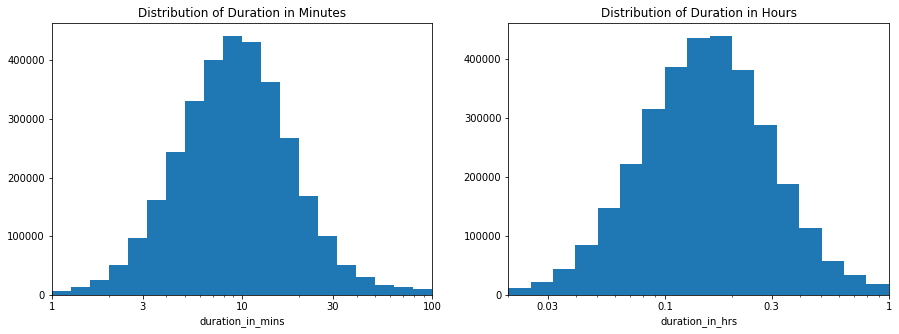

In [19]:
# Histogram for duration_in_mins 
plt.figure(figsize = [15,5] )

plt.subplot(1,2,1)
bins_edges = 10**np.arange(0,3.15+0.1,0.1)
ticks = [1,3,10,30,100,300,1000]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df, x = 'duration_in_mins' ,bins = bins_edges)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('duration_in_mins')
plt.title('Distribution of Duration in Minutes')
plt.xlim((1,100))


plt.subplot(1,2,2)
bins_edges = 10**np.arange(-1.8,1.35+0.1,0.1)
ticks = [0.01,0.03,0.1,0.3,1,3,10]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df, x = 'duration_in_hrs' ,bins = bins_edges)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('duration_in_hrs')
plt.title('Distribution of Duration in Hours')
plt.xlim(0.02,1);

- From the above histogram it can be observed that 400k+ data points fall near by the 10 mins mark in first subplot and 0.15 hrs in second subplot.
- This looks like a normal distribution.

## Which user_type are more in the data? Customers or Subscribers?

### Exploring the user_type variable (Categorical)

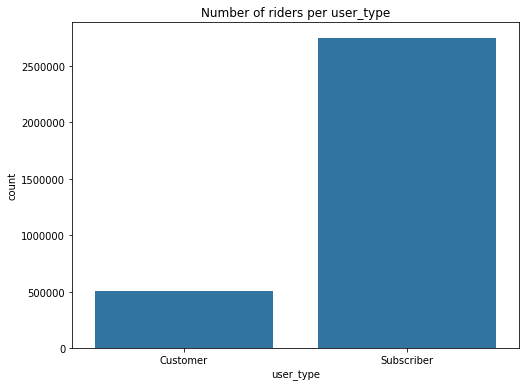

In [20]:
# Exploring the user_type variable which is categorical Variable
plt.figure(figsize = [8,6])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'user_type', color = base_color)
plt.title('Number of riders per user_type');

- It is clearly evident from the data that There are more subscribers than customers for the lyft bikes

## What type of gender uses the bike sevices more? Male, Female or Other?

### Exploring member_gender Variable (Categorical)

In [21]:
# Making a copy of df 
df1 = df.copy()

In [22]:
# Filling up the Nan values with the probabilities 
prob = df1.member_gender.value_counts(normalize = True)
missing = df1.member_gender.isnull()
df1.loc[missing,'member_gender'] = np.random.choice(prob.index, size=len(df1[missing]),p=prob.values)

In [23]:
# Checking the df1
df1.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_in_mins,duration_in_hrs
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,NaN,1335.166667,22.252778
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,NaN,1313.333333,21.888889
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,Male,NaN,762.800000,12.713333
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,Female,NaN,1036.200000,17.270000
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,NaN,726.716667,12.111944


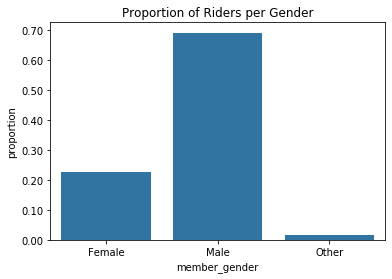

In [24]:
# Exploring member_gender Variable which is also a categorical variable
n_points = df.shape[0]
max_count = df['member_gender'].value_counts().max()
max_prop = max_count / n_points

tick_props = np.arange(0, max_prop+0.1, 0.1)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'member_gender', color = base_color)
plt.title('Proportion of Riders per Gender')
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('proportion');

- From the above countplot we can observet that 69% of Riders are Male 22% of the Riders are Female and 2% of the Riders are Other. The remaining 7% of the values are not available.

In [25]:
df.member_gender.value_counts()/df.shape[0]

Male      0.691734
Female    0.226065
Other     0.015295
Name: member_gender, dtype: float64

In [26]:
df1.member_gender.value_counts()/df1.shape[0]

Male      0.741540
Female    0.242081
Other     0.016379
Name: member_gender, dtype: float64

## People of which age uses the bike services?

### Exploring the age variable (Quantitive)

In [27]:
# Age of the Riders
df['age'] = 2019 - df['member_birth_year']

In [28]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_in_mins,duration_in_hrs,age
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,NaN,1335.166667,22.252778,32.0
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,NaN,1313.333333,21.888889,54.0
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN,762.800000,12.713333,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN,1036.200000,17.270000,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,NaN,726.716667,12.111944,22.0


In [29]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,member_birth_year,duration_in_mins,duration_in_hrs,age
count,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.241824e+06,3.254325e+06,3.254325e+06,3.036159e+06,3.254325e+06,3.254325e+06,3.036159e+06
mean,8.743223e+02,1.209191e+02,3.776880e+01,-1.223530e+02,1.191966e+02,3.776874e+01,-1.223519e+02,1.983137e+03,1.457204e+01,2.428673e-01,3.586325e+01
std,2.468547e+03,1.030184e+02,1.029275e-01,1.601559e-01,1.029334e+02,1.342571e-01,3.220803e-01,1.043760e+01,4.114245e+01,6.857075e-01,1.043760e+01
min,6.100000e+01,3.000000e+00,0.000000e+00,-1.224737e+02,3.000000e+00,0.000000e+00,-1.224737e+02,1.878000e+03,1.016667e+00,1.694444e-02,1.800000e+01
25%,3.510000e+02,3.100000e+01,3.777106e+01,-1.224117e+02,3.000000e+01,3.777143e+01,-1.224108e+02,1.978000e+03,5.850000e+00,9.750000e-02,2.800000e+01
50%,5.570000e+02,8.800000e+01,3.778107e+01,-1.223983e+02,8.700000e+01,3.778127e+01,-1.223974e+02,1.985000e+03,9.283333e+00,1.547222e-01,3.400000e+01
75%,8.730000e+02,1.880000e+02,3.779539e+01,-1.222934e+02,1.860000e+02,3.779625e+01,-1.222935e+02,1.991000e+03,1.455000e+01,2.425000e-01,4.100000e+01
max,8.636900e+04,4.200000e+02,4.551000e+01,0.000000e+00,4.200000e+02,4.551000e+01,0.000000e+00,2.001000e+03,1.439483e+03,2.399139e+01,1.410000e+02


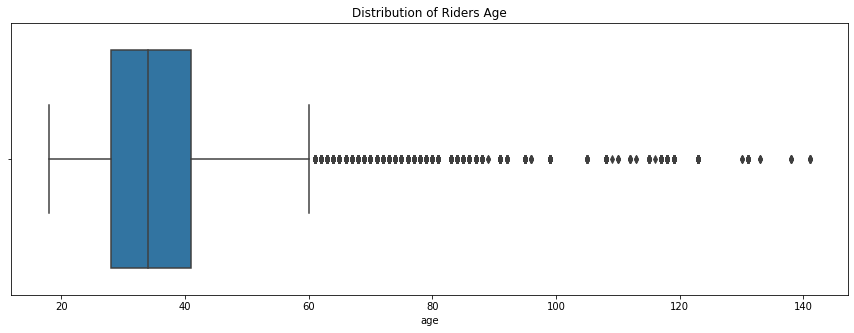

In [30]:
# Distribution of age variable
plt.figure(figsize = [15,5])
base_color = sb.color_palette()[0]
sb.boxplot(data = df, x = 'age', color = base_color)
plt.title('Distribution of Riders Age');

- The age greater than 100 is not possible as the life expectancy in US is 80 years. 91% of the riders are below or equal to 60 and greater than 18. The average age of Riders being 35 approximately.

In [31]:
percentage_of_riders_below_60 = df.query('age <= 60').shape[0]/df.shape[0]
percentage_of_riders_below_60

0.9092834919683805

# What is the distance between two stations?

### Exploring the distance for the datapoints in df (LatLon)

In [32]:
# Exploring the distance for the datapoints in df
# Haversine is used to calculate distance between two points

ride_distance = []
for i in range(df.shape[0]):
    start_point = (df['start_station_latitude'][i],df['start_station_longitude'][i])
    end_point = (df['end_station_latitude'][i],df['end_station_longitude'][i])
    ride_distance.append(haversine(start_point,end_point,unit = 'mi' ))   

In [33]:
# Adding the column ride_distance to the df
df['ride_distance'] = np.array(ride_distance)

In [34]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_in_mins,duration_in_hrs,age,ride_distance
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male,NaN,1335.166667,22.252778,32.0,0.585911
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female,NaN,1313.333333,21.888889,54.0,1.907443
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN,762.800000,12.713333,NaN,0.000000
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN,1036.200000,17.270000,NaN,0.650342
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female,NaN,726.716667,12.111944,22.0,0.395404


In [35]:
df.ride_distance.describe()

count    3.254325e+06
mean     1.055915e+00
std      1.921920e+01
min      0.000000e+00
25%      5.502277e-01
50%      8.699054e-01
75%      1.322285e+00
max      7.952535e+03
Name: ride_distance, dtype: float64

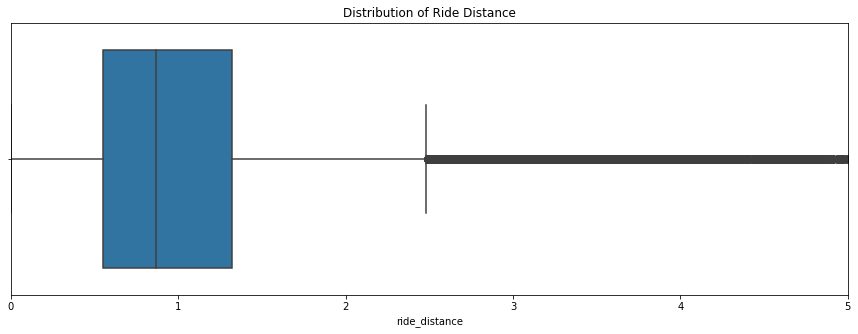

In [36]:
# Distribution of ride_distance
plt.figure(figsize = [15,5])
base_color = sb.color_palette()[0]
sb.boxplot(data = df, x = 'ride_distance', color = base_color)
plt.title('Distribution of Ride Distance')
plt.xlim((0,5));

- Riding 8000 miles on a bike is rediculous. Hence limited the x axis from the description of the ride_distance. The median is between 0.8 and 0.9 ~ 0.85 miles.

## What time of the day is the peak(rush) hours for the bikes?

### Exploring the rush Hours of the day (Categorical)

In [37]:
# From the start_time, end_time date is extracted and addted to new columns
df['start_date']=df['start_time'].dt.date
df['end_date']=df['end_time'].dt.date

# def day_week(df = df,col = None ):
#     emp_list = []
#     for i in range(df.shape[0]):
#         emp_list.append(df[col][i].weekday())
#     return emp_list

# From the start_time, end_time weekday_name is extracted and addted to new columns
df['start_day']=df['start_time'].dt.weekday_name
df['end_day']=df['end_time'].dt.weekday_name

# From the start_time, end_time weekday_name is extracted and addted to new columns and converted the hours to category type
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour
df['start_time_hour'] = df['start_time_hour'].astype('category') 
df['end_time_hour'] = df['end_time_hour'].astype('category') 

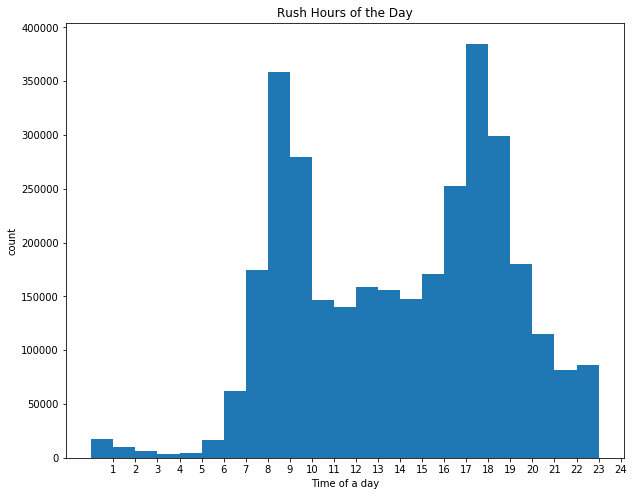

In [38]:
# Exploring the rush hours of the day
plt.figure(figsize = [10,8])
bins = np.arange(0,23+1,1)
ticks = [i for i in range(1,25)]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df, x = 'start_time_hour',bins = bins)
plt.xticks(ticks,labels)
plt.title('Rush Hours of the Day')
plt.xlabel('Time of a day')
plt.ylabel('count');

- The above histogram is bimodal the first peak hour of the day is in between (8-9) and the second peak hour is in between (17-18). That is the peak hours are from morning 8:00 AM - 9:00 AM and 5:00 PM - 6:00 PM

## Exploring Bivariate Plots

## How are the duration duration_in_mins, age, ride_distance variables related? 

### Exploring the relation for duration_in_mins, age, ride_distance variables (All are Quantitative)

In [39]:
df1 = df.copy()

In [40]:
df1 = df1[['duration_in_mins','age','ride_distance']]

In [41]:
df1.head()

,duration_in_mins,age,ride_distance
0,1335.166667,32.0,0.585911
1,1313.333333,54.0,1.907443
2,762.800000,NaN,0.000000
3,1036.200000,NaN,0.650342
4,726.716667,22.0,0.395404


C:\Users\durga\AppData\Local\Continuum\anaconda3\envs\DAND\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\durga\AppData\Local\Continuum\anaconda3\envs\DAND\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


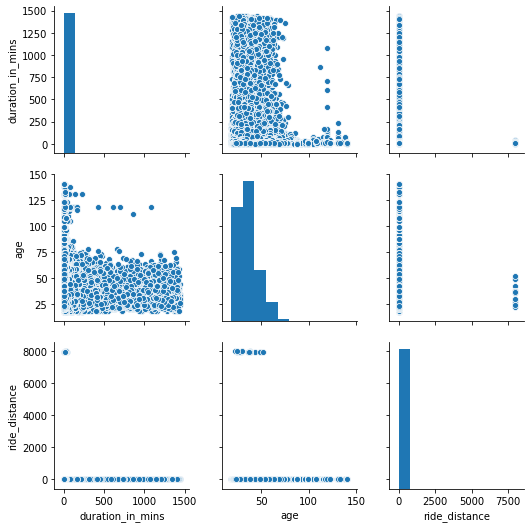

In [42]:
# Plotting distance,duration and age
sb.pairplot(df1)

- Not able to explore any clear patterns

## What is the duration_in_mins for people of all kinds of age in the dataset?

### Exploring relation two quatitative variables (age,duration_in_mins)

Text(0, 0.5, 'Age')

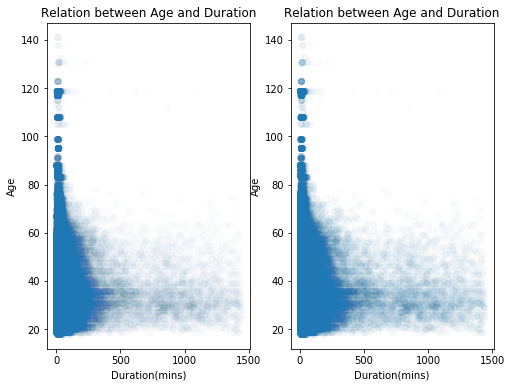

In [43]:
# Exploring relation two quatitative variables (age,duration_in_mins)
plt.figure(figsize = [8,6])
plt.subplot(1,2,1)
plt.scatter(data = df,x = 'duration_in_mins', y = 'age', alpha = 1/100)
plt.title('Relation between Age and Duration')
plt.xlabel('Duration(mins)')
plt.ylabel('Age')

plt.subplot(1,2,2)
plt.scatter(data = df,x = 'duration_in_mins', y = 'age', alpha = 1/50)
plt.title('Relation between Age and Duration')
plt.xlabel('Duration(mins)')
plt.ylabel('Age')

- Apart from outliers Age and Distance seem to have a negative relation but the scatter plot is unable to depict the exact relation

## Can we have different groups for people of different age?

### Making the age as categorical variable and adding it to a new column

In [44]:
# Creating age groups and converting it as categorical variable
df['age_groups'] = df['age'].apply(lambda x: '10-20' if 10<x<=20
                                                    else '20-30' if 20<x<=30
                                                    else '30-40' if 30<x<=40
                                                    else '40-50' if 40<x<=50
                                                    else '50-60' if 50<x<=60
                                                    else '60+')

df.age_groups = df.age_groups.astype('category')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 27 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  category
member_birth_year          float64
member_gender              category
bike_share_for_all_trip    object
duration_in_mins           float64
duration_in_hrs            float64
age                        float64
ride_distance              float64
start_date                 object
end_date                   object
start_day                  object
end_day                    object
start_time_hour            category
end_t

Text(0.5, 1.0, 'Relation between trip duration and age')

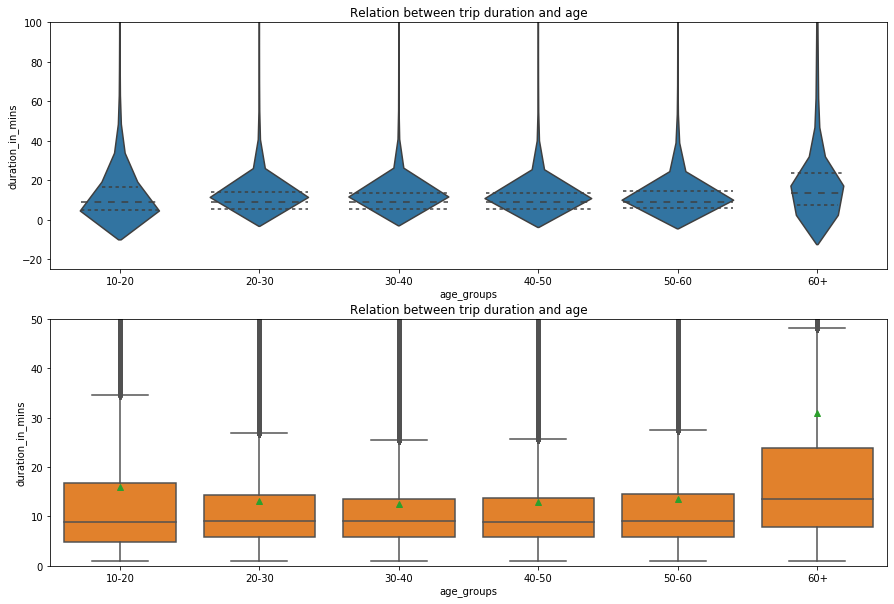

In [46]:
# Exploring relation between Age and Duration
plt.figure(figsize=[15,10])
plt.subplot(2,1,1)
base_color = sb.color_palette()[0]
sb.violinplot(data = df, x = 'age_groups', y = 'duration_in_mins', color = base_color, inner = 'quartile')
plt.ylim(-25,100);
plt.title('Relation between trip duration and age')

plt.subplot(2,1,2)
base_color = sb.color_palette()[1]
sb.boxplot(data = df, x = 'age_groups', y = 'duration_in_mins', color = base_color, showmeans = True)
plt.ylim(0,50)
plt.title('Relation between trip duration and age')

- The riders of age groups 30-40, 40-50 on average ride less compared to the overall poppulation. Here boxplot provdies better visualization

## What is the distance travelled by by people of all kinds of ages in the dataset?

### Exploring relation between Age and Distance

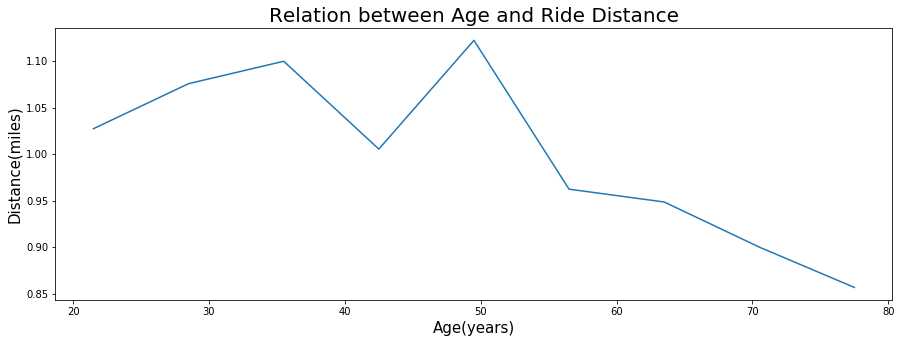

In [47]:
# Exploring relation between Age and Distance 
# set bin edges, compute centers
bin_size = 7
xbin_edges = np.arange(18, 80+bin_size, bin_size)
xbin_centers = (xbin_edges + bin_size/2)[:-1]

# compute statistics in each bin by using the cut function
data_xbins = pd.cut(df['age'], xbin_edges, right = False, include_lowest = True)
y_means = df['ride_distance'].groupby(data_xbins).mean()

# plot the summarized data
plt.figure(figsize = [15,5])
plt.errorbar(x = xbin_centers, y = y_means)
plt.title('Relation between Age and Ride Distance',fontsize =20)
plt.xlabel('Age(years)',fontsize =15)
plt.ylabel('Distance(miles)',fontsize =15);

- Age and distance have negative correlation i.e, if age increases ride distance decreases

## What type of gender uses the sevice most in customers and subscribers?

### Exploring the relation between categorical variables 'user_type' and 'member_gender'

In [48]:
# Exploring the relation between categorical variables 'user_type' and 'member_gender' 
member_counts = df.groupby(['user_type','member_gender']).size()
member_counts = member_counts.reset_index(name = 'count')
member_counts = member_counts.pivot(index = 'member_gender', columns = 'user_type', values = 'count')

In [49]:
member_counts

user_type,Customer,Subscriber
member_gender,,
Female,106363,629327
Male,232094,2019034
Other,7382,42392


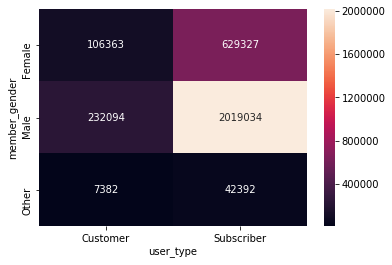

In [50]:
# Heatmap
sb.heatmap(member_counts,annot = True, fmt ='d');

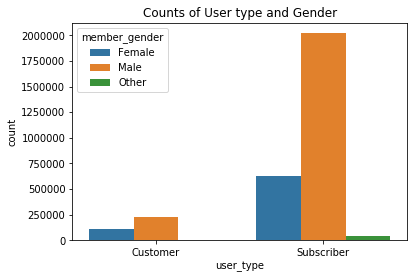

In [51]:
# Clustered Bar Chart
sb.countplot(data = df, x = 'user_type', hue = 'member_gender')
plt.title('Counts of User type and Gender');

- There are more number of Male subscribers than Male customers, similarly more number Female subscribers than Female customers

# Multivariate Analysis

In [53]:
# Ordering the age_groups in an asceding order
ages = ['10-20', '20-30', '30-40', '40-50', '50-60', '>60']
age_grps = pd.api.types.CategoricalDtype(ordered = True, categories = ages)
df['age_groups'] = df['age_groups'].astype(age_grps)

## How are the variables age, distance  and duration related?

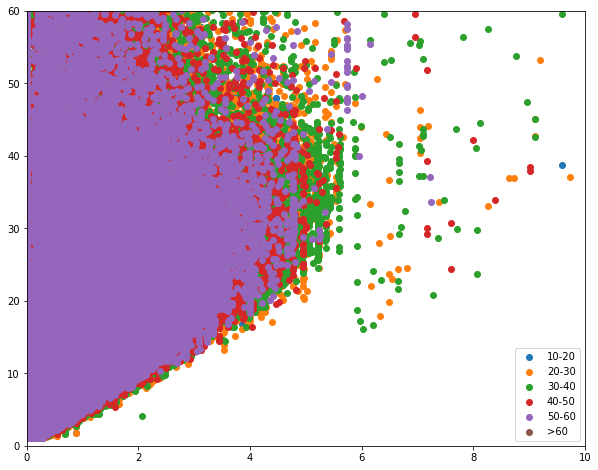

In [54]:
# one categeorical variable age_groups and two quantitative variables distance and duration

plt.figure(figsize = [10,8])
for cat in ages:
    df_cat = df[df['age_groups'] == cat]
    plt.scatter(data = df_cat, x = 'ride_distance', y = 'duration_in_mins', marker = 'o')
plt.legend(['10-20', '20-30', '30-40', '40-50', '50-60', '>60'])
plt.xlim(0,10)
plt.ylim(0,60);

- As there are several datapoints the patterns are not super clear. But, we can say that riders of age groups 40-50 travel more distance compared to (50-60) group. Groups (20-30),(30-40) travel more distances that the (40-50),(50-60) groups. We can observe kind of normal distribution if we swap the axes.  

In [55]:
# Defining function to create mean_y bins  
def mean_poly(x, y, bins = 10, **kwargs):
    """ Custom adapted line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linspace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # compute counts
    data_bins = pd.cut(x, bins, right = False,
                       include_lowest = True)
    means = y.groupby(data_bins).mean()

    # create plot
    plt.errorbar(x = bin_centers, y = means, **kwargs)

C:\Users\durga\AppData\Local\Continuum\anaconda3\envs\DAND\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


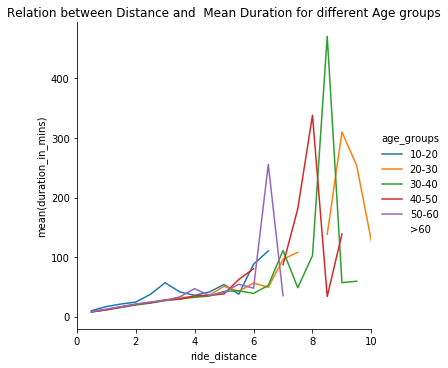

In [56]:
# Relation between Distance and Duration for different Age groups    

bin_edges = np.arange(0.25, df['ride_distance'].max()+0.5, 0.5)
g = sb.FacetGrid(data = df, hue = 'age_groups', size = 5)
g.map(mean_poly, "ride_distance", "duration_in_mins", bins = bin_edges)
g.set_ylabels('mean(duration_in_mins)')
g.add_legend()
plt.xlim(0,10)
plt.title('Relation between Distance and  Mean Duration for different Age groups');

- People of age group 30-40 who covers a distance of 8.7 miles takes a mean time of 450 mins. This might be caused because they take more stops/intervals. zigzag patterns are observed. 

## How are different age groups taking rides on different days and what are their duration and distance?
### Exploring the relation of quantitative variables duration and distance with categorical variables day and age groups

In [57]:
# Making a copy of the dataframe  
df2 = df.copy()

In [58]:
# Creating a new df with the ride distance less than 3.5 miles 
df2 = df2.query('ride_distance <= 3.5 and duration_in_mins <= 50.00').reset_index()

df2.drop(columns = ['index'],inplace = True)

df2.shape

(3169136, 27)

In [59]:
df2.duration_in_mins.max()

50.0

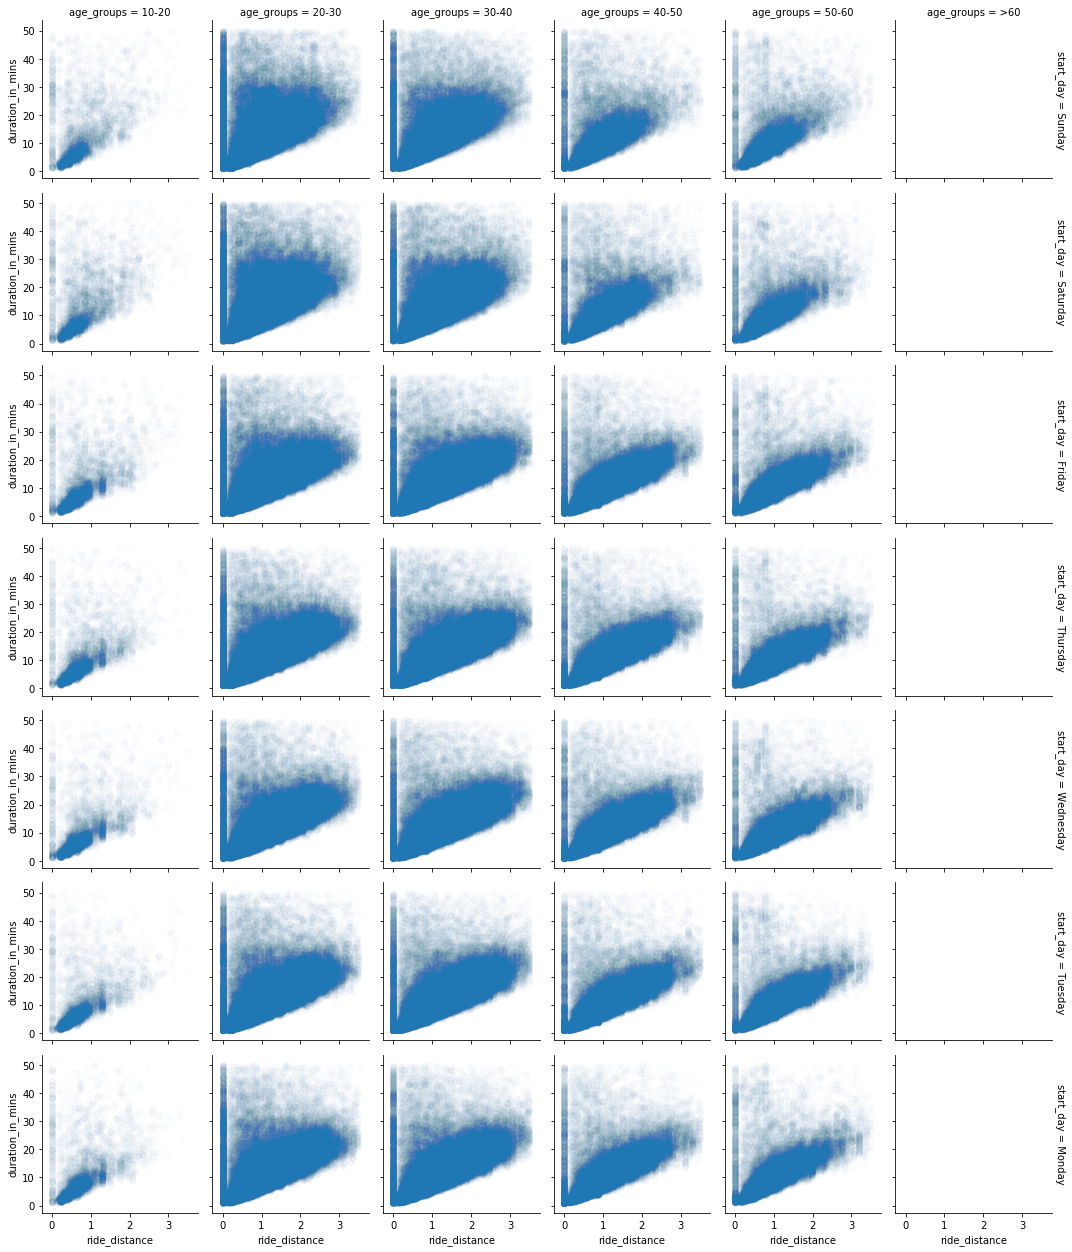

In [60]:
g = sb.FacetGrid(data = df2, col = 'age_groups', row = 'start_day', size = 2.5,
                margin_titles = True)
g.map(plt.scatter, 'ride_distance', 'duration_in_mins', alpha = 1/100);

Its hard to depict the relation from the above plots. Hence taking a sample of 10000 rows to get some insights. 

In [61]:
# Creating a sample
df3 = df2.sample(10000)

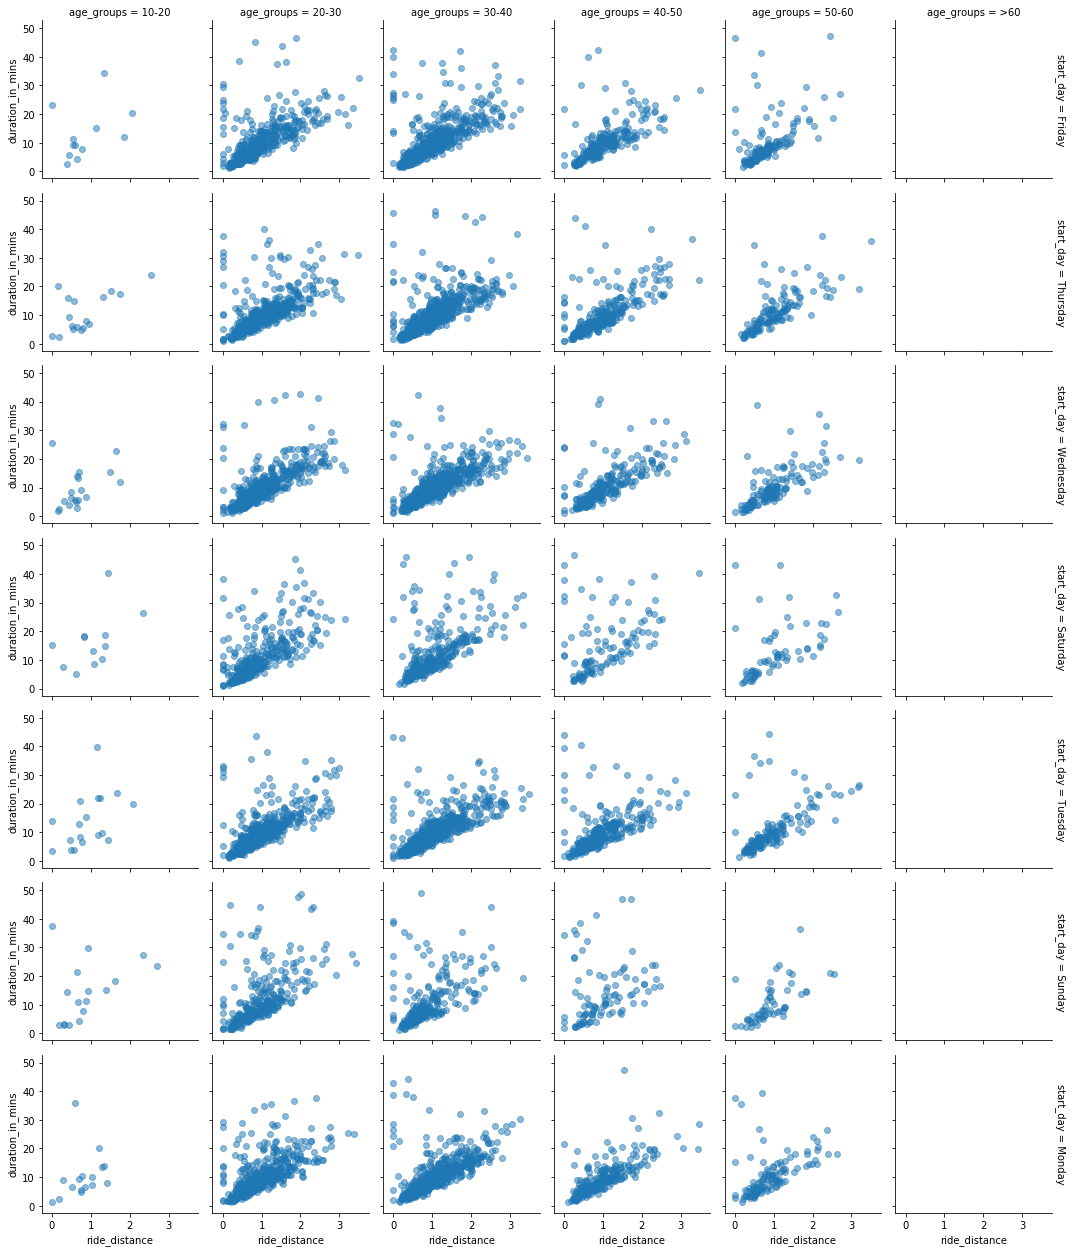

In [62]:
# Scatter plot on the sample data
g = sb.FacetGrid(data = df3, col = 'age_groups', row = 'start_day', size = 2.5,
                margin_titles = True)
g.map(plt.scatter, 'ride_distance', 'duration_in_mins', alpha = 0.5);

- From the sample we can see that few bike riders between age group 10-20 on any day in a week shows a positive relation which is weak. 
- The next three age groups (20-30),(30-40),(40-50) show strong positve relation. From these plots we can say that on any day of the week more bike riders use the bikes and as they travel more distance the duration in mins also increases. 
- The group (50-60) shows similar trend as the previous three where are the riders are comparatively low.
- As we removed the group(>60) for the df3 no datapoints are plotted.

In [64]:
df.to_csv('lyftbikes_data.csv')